In [1]:
%matplotlib inline
import numpy as np
import torch
import torch.optim as optim

In [2]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) # <1>
t_u = torch.tensor(t_u).unsqueeze(1) # <1>

t_u.shape

torch.Size([11, 1])

In [4]:
n_samples = t_u.shape[0]
n_val = int(0.2*n_samples)
shuffled_indices = torch.randperm(n_samples)
train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]
train_indices, val_indices

(tensor([8, 1, 7, 6, 9, 2, 4, 5, 3]), tensor([10,  0]))

In [5]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

In [6]:
import torch.nn as nn

linear_model = nn.Linear(1,1)
linear_model(t_un_val)

tensor([[-3.1045],
        [-1.3260]], grad_fn=<AddmmBackward>)

In [7]:
linear_model.weight

Parameter containing:
tensor([[-0.5439]], requires_grad=True)

In [8]:
linear_model.bias

Parameter containing:
tensor([0.6156], requires_grad=True)

In [9]:
x = torch.ones(1)
linear_model(x)

tensor([0.0717], grad_fn=<AddBackward0>)

In [10]:
x = torch.ones(10,1)
linear_model(x)

tensor([[0.0717],
        [0.0717],
        [0.0717],
        [0.0717],
        [0.0717],
        [0.0717],
        [0.0717],
        [0.0717],
        [0.0717],
        [0.0717]], grad_fn=<AddmmBackward>)

In [15]:
linear_model = nn.Linear(1,1)
optimizer = optim.SGD(linear_model.parameters(),
                     lr=1e-2)

In [16]:
linear_model.parameters()

<generator object Module.parameters at 0x7faf90bec8e0>

In [20]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[-0.5434]], requires_grad=True),
 Parameter containing:
 tensor([-0.7667], requires_grad=True)]

In [24]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val, ):
    for epoch in range(1, n_epochs+1):
        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train, t_c_train)
        t_p_val = model(t_u_val)
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        
        if epoch == 1 or epoch % 1000 == 0:
            print("Epoch{}, Training loss{}, Validation loss{}".format(epoch, float(loss_train), float(loss_val)))

In [26]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p-t_c)**2
    return squared_diffs.mean()

linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(n_epochs=3000,
             optimizer=optimizer,
             model=linear_model,
             loss_fn=loss_fn,
             t_u_train=t_un_train,
             t_u_val=t_un_val,
             t_c_train=t_c_train,
             t_c_val=t_c_val)

print(linear_model.weight)
print(linear_model.bias)

Epoch1, Training loss245.13546752929688, Validation loss291.58099365234375
Epoch1000, Training loss3.886125326156616, Validation loss7.577693939208984
Epoch2000, Training loss3.0101728439331055, Validation loss3.9676895141601562
Epoch3000, Training loss2.9803600311279297, Validation loss3.437800884246826
Parameter containing:
tensor([[5.1383]], requires_grad=True)
Parameter containing:
tensor([-16.1343], requires_grad=True)


In [27]:
seq_model = nn.Sequential(nn.Linear(1,13),
                         nn.Tanh(),
                         nn.Linear(13,1))
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [28]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

In [30]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [33]:
from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([
    ("hidden_linear", nn.Linear(1,8)),
    ("hidden_activation", nn.Tanh()),
    ("output_linear", nn.Linear(8,1))
]))
seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [36]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [38]:
seq_model.output_linear.bias

Parameter containing:
tensor([0.3058], requires_grad=True)

In [39]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)

training_loop(n_epochs=5000,
             optimizer=optimizer,
             model=seq_model,
             loss_fn=nn.MSELoss(),
             t_u_train=t_un_train,
             t_u_val=t_u_val,
             t_c_train=t_c_train,
             t_c_val=t_c_val)

print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch1, Training loss180.1161651611328, Validation loss215.74981689453125
Epoch1000, Training loss6.129748821258545, Validation loss294.5618591308594
Epoch2000, Training loss3.640392303466797, Validation loss424.2518615722656
Epoch3000, Training loss2.060279369354248, Validation loss494.9136047363281
Epoch4000, Training loss1.884168028831482, Validation loss529.28955078125
Epoch5000, Training loss1.8135013580322266, Validation loss544.7008056640625
output tensor([[20.6717],
        [ 2.6934]], grad_fn=<AddmmBackward>)
answer tensor([[21.0000],
        [ 0.5000]])
hidden tensor([[-0.0014],
        [-0.0018],
        [-0.0090],
        [ 0.0794],
        [-0.0138],
        [-0.0267],
        [ 0.0010],
        [-0.0039]])


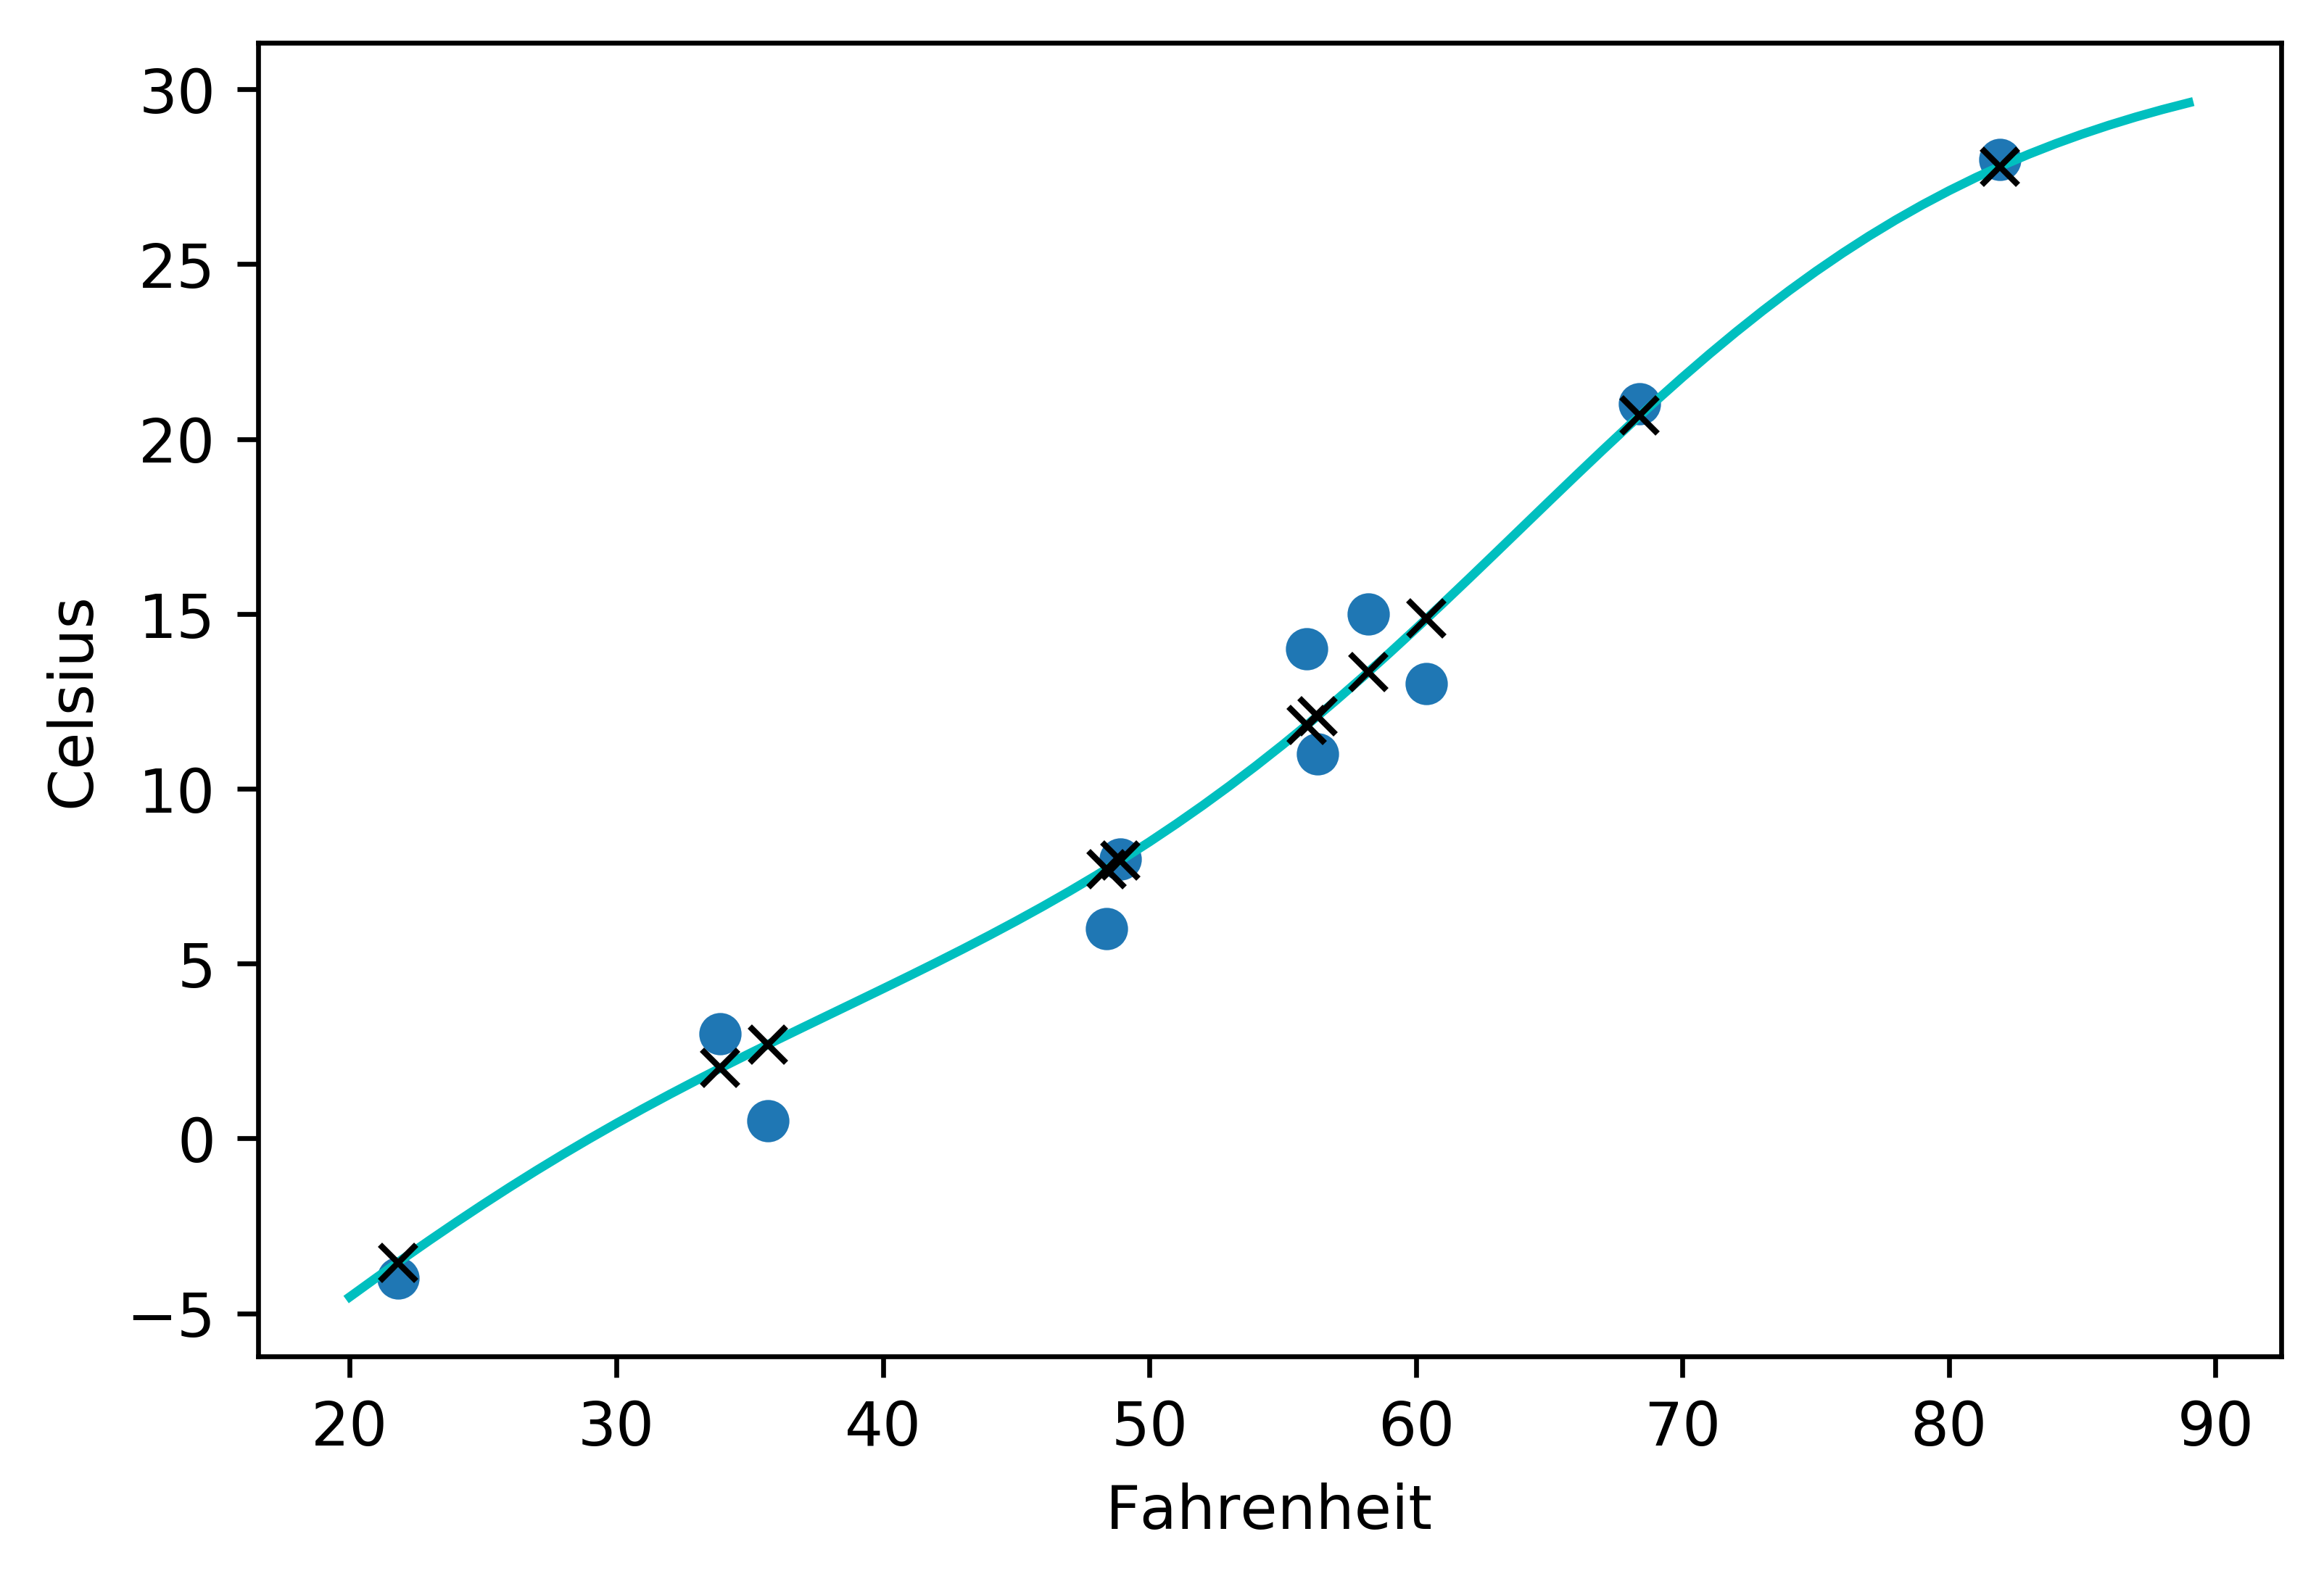

In [40]:
from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')

Epoch1, Training loss180.28659057617188, Validation loss220.8422088623047
Epoch1000, Training loss53.41654968261719, Validation loss84.63203430175781
Epoch2000, Training loss35.66544723510742, Validation loss56.795921325683594
Epoch3000, Training loss24.489017486572266, Validation loss38.434661865234375
Epoch4000, Training loss16.5455265045166, Validation loss24.352603912353516
Epoch5000, Training loss11.757405281066895, Validation loss15.310556411743164


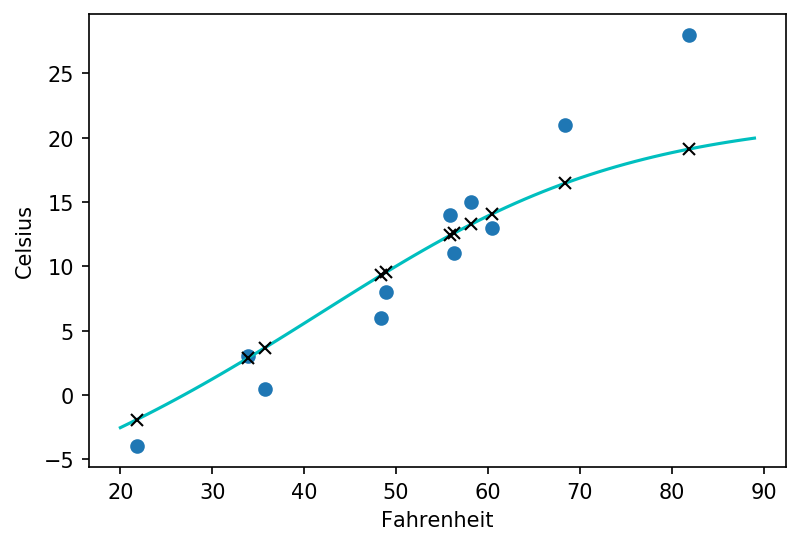

In [47]:
#exercise
neuron_count = 13

seq_model = nn.Sequential(OrderedDict([
    ("hidden_linear", nn.Linear(1, neuron_count)),
    ("hidden_activation", nn.Tanh()),
    ("output_linear", nn.Linear(neuron_count, 1))
]))

optimizer = optim.SGD(seq_model.parameters(), lr=1e-4)

training_loop(n_epochs=5000,
             optimizer=optimizer,
             model=seq_model,
             loss_fn=nn.MSELoss(),
             t_u_train=t_un_train,
             t_u_val=t_un_val,
             t_c_train=t_c_train,
             t_c_val=t_c_val)

from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=150)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')